# Imports

In [1]:
# basics
import os
import gc
import math
import pickle
import numpy as np
import pandas as pd
from time import time
from dataclasses import dataclass

# scipy
import scipy.sparse as sp

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# torch
import torch
from torch.utils.data import Dataset, DataLoader

# retrieval topK
import heapq  

In [2]:
# To get deterministic experiments 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2357 # only primers ;)
 
def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Experimento deterministico, seed: {manual_seed} -- ', end = '')
        print(f'Existe {torch.cuda.device_count()} GPU\
 {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Experimento randomico')
deterministic()

Experimento deterministico, seed: 2357 -- Existe 1 GPU Tesla V100-SXM2-16GB disponível.


# Data prep

In [3]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/RecSys/movielens_datasets/ml100k/ml-100k.zip
!mkdir Data

INPUT_PATH = 'ml-100k/u.data'

OUTPUT_PATH_TRAIN = 'Data/movielens.train.rating'
OUTPUT_PATH_TEST = 'Data/movielens.test.rating'
USER_FIELD = 'userID'

Archive:  /content/drive/MyDrive/Colab Notebooks/RecSys/movielens_datasets/ml100k/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [4]:
def save_to_csv(df,path, header=False, index=False, sep='\t', verbose=False):
    if verbose:
        print("Saving df to path: {}".format(path))
        print("Columns in df are: {}".format(df.columns.tolist()))

    df.to_csv(path, header=header, index=index, sep=sep)

def get_train_test_df(transactions):
    print("Size of the entire dataset:{}".format(transactions.shape))
    transactions.sort_values(by=['timestamp'], inplace=True)
    last_transaction_mask = transactions.duplicated(subset={USER_FIELD}, keep="last")
    train_df = transactions[last_transaction_mask]
    test_df = transactions[~last_transaction_mask]
    
    train_df.sort_values(by=["userID", 'timestamp'], inplace=True)
    test_df.sort_values(by=["userID", 'timestamp'], inplace=True)
    return train_df, test_df

def report_stats(transactions, train_df, test_df):
    whole_size = transactions.shape[0]*1.0
    train_size = train_df.shape[0]
    test_size = test_df.shape[0]
    print("Total No. of Records = {}".format(whole_size))
    print("Train size = {}, Test size = {}".format(train_size, test_size))
    print("Train % = {}, Test % ={}".format(train_size/whole_size, test_size/whole_size))

transactions = pd.read_csv(
    INPUT_PATH, 
    sep="\t", 
    names=['userID', 'movieID', 'rating', 'timestamp'], 
    engine='python'
    )

transactions['rating'] = 1

# --> make the dataset
train_df, test_df = get_train_test_df(transactions)
save_to_csv(train_df, OUTPUT_PATH_TRAIN, header=False, index=False, verbose=1)
save_to_csv(test_df, OUTPUT_PATH_TEST, header=False, index=False, verbose=1)
report_stats(transactions, train_df, test_df)

Size of the entire dataset:(100000, 4)
Saving df to path: Data/movielens.train.rating
Columns in df are: ['userID', 'movieID', 'rating', 'timestamp']
Saving df to path: Data/movielens.test.rating
Columns in df are: ['userID', 'movieID', 'rating', 'timestamp']
Total No. of Records = 100000.0
Train size = 99057, Test size = 943
Train % = 0.99057, Test % =0.00943


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# Dataset

In [5]:
def load_train(filename):
    num_users, num_items = 0, 0
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            u, i = int(arr[0]), int(arr[1])
            num_users = max(num_users, u)
            num_items = max(num_items, i)
            line = f.readline()
    
    mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
            if (rating > 0):
                mat[user, item] = 1.0
            line = f.readline()
    return mat

In [6]:


@dataclass
class PrepData:
    filename_test: str
    num_negatives_train: int
    num_negatives_test: int
    train: object

    def get_train_instances(self):
        train = self.train
        num_negatives = self.num_negatives_train
        user_input, item_input, ratings = [], [], []
        num_users, num_items = train.shape

        for (u, i) in train.keys():
            # positive instance
            user_input.append(u)
            item_input.append(i)
            ratings.append(1)
            # negative instances
            for _ in range(num_negatives):
                j = np.random.randint(1, num_items)
                # while train.has_key((u, j)):
                while (u, j) in train:
                    j = np.random.randint(1, num_items)
                user_input.append(u)
                item_input.append(j)
                ratings.append(0)
        return user_input, item_input, ratings

    def load_test(self):
        ratingList = []
        with open(self.filename_test, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def get_test_instances(self):
        _, num_items = self.train.shape
        testRatings = self.load_test()

        negativeList = []
        for user_item_pair in testRatings:
            user = user_item_pair[0]
            item = user_item_pair[1]
            negatives = []
            for t in range(self.num_negatives_test):
                j = np.random.randint(1, num_items)
                while (user, j) in self.train or j == item:
                    j = np.random.randint(1, num_items)
                negatives.append(j)
            negativeList.append(negatives)
        return negativeList


class RecSysDataset(Dataset):

    def __init__(self, train_data):
        self.user_input, self.item_input, self.ratings = train_data

    def __len__(self):
        return len(self.user_input)

    def __getitem__(self, index):
        user_id = self.user_input[index]
        item_id = self.item_input[index]
        rating = self.ratings[index]

        return {'user_id': user_id, 'item_id': item_id, 'rating': rating}


# --> Testing Class DataPrep        
train_matrix = load_train('Data/movielens.train.rating')

PrepData = PrepData(
    filename_test='Data/movielens.test.rating',
    num_negatives_train=4,
    num_negatives_test=100,
    train=train_matrix
) 

train_data = PrepData.get_train_instances()
test_negatives = PrepData.get_test_instances()
test_ratings  = PrepData.load_test()

# --> Testing RecSysDataset

ds = RecSysDataset(train_data)

ds_dict = ds[0]
print('Testing RecSysDataset')
print(f"user_id: {ds_dict['user_id']}, item_id: {ds_dict['item_id']}, rating: {ds_dict['rating']}")

print(f"train: {train_matrix.shape}, testRatings: {len(test_ratings)}, testNegatives: {len(test_negatives)}")
print(f"num_users: {train_matrix.shape[0]}, num_items: {train_matrix.shape[1]}")

Testing RecSysDataset
user_id: 1, item_id: 168, rating: 1
train: (944, 1683), testRatings: 943, testNegatives: 943
num_users: 944, num_items: 1683


# Dataloader

In [7]:
BATCH_SZ = 256

dataset_train = RecSysDataset(train_data)

train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SZ,
    shuffle=True, 
    num_workers=os.cpu_count(), 
    pin_memory=True
    )

# --> Testing Dataloader
dict_loader = next(iter(train_loader))
print(f"user_id: {dict_loader['user_id'].shape}, item_id: {dict_loader['item_id'].shape}, rating: {dict_loader['rating'].shape}")

print('len dataloader:', len(train_loader))

user_id: torch.Size([256]), item_id: torch.Size([256]), rating: torch.Size([256])
len dataloader: 1935


# Model

In [20]:
class RecSysNet(torch.nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=32, out=1):
        super().__init__()

        self.activation = torch.nn.GELU()
        self.drop = torch.nn.Dropout(0.3)
        
        self.user_embeds = torch.nn.Embedding(n_users, embedding_dim//4, 
                                              scale_grad_by_freq=True)
        self.item_embeds = torch.nn.Embedding(n_items, 3 * embedding_dim//4, 
                                              scale_grad_by_freq=True)

        self.fc0 = torch.nn.Linear(embedding_dim, 2 * embedding_dim)
        self.fc1 = torch.nn.Linear(2 * embedding_dim, embedding_dim//2)

        self.output_layer = torch.nn.Linear(embedding_dim//2, out)
  
    def forward(self, input_dict):
        user_embeds = self.user_embeds(input_dict['user_id'])
        item_embeds = self.item_embeds(input_dict['item_id'])

        x = torch.cat([user_embeds, item_embeds], dim=1)
        o = self.drop(self.activation(self.fc0(x)))
        o = self.activation(self.fc1(o))
        logit = self.output_layer(o)

        return logit

# --> Testing the Network
try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

model = RecSysNet(
    n_users=train_matrix.shape[0], 
    n_items=train_matrix.shape[1], 
    embedding_dim=128
)    

with torch.no_grad():
    out = model(dict_loader)
print(f'out forward shape: {out.shape}', end= '  --  ')
print(f'out sample: {out[0]}')

out forward shape: torch.Size([256, 1])  --  out sample: tensor([0.0592])


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
_ = 50

print('\n','#' * _, f'\n # Número de params. {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * _,'\n')  
model


 ################################################## 
 # Número de params. 241,313 trainable parameters #
 ################################################## 



RecSysNet(
  (activation): GELU()
  (drop): Dropout(p=0.3, inplace=False)
  (user_embeds): Embedding(944, 32, scale_grad_by_freq=True)
  (item_embeds): Embedding(1683, 96, scale_grad_by_freq=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

# Train and Evaluate functions 

In [23]:
def train_one_epoch(model, data_loader, loss_fn, optimizer, epoch_no, num_epoch, device, verbose=True):
    print(f"Epoch [{epoch_no}/{num_epoch}]: ", end= '')
    epoch_loss = []
    model.train()
    for dict_train in data_loader:
        optimizer.zero_grad()
        
        for key in dict_train:
            if type(dict_train[key]) != type(None):
                dict_train[key] = dict_train[key].to(dtype=torch.long, device=device)

        rating_prediction = model(dict_train)

        rating_true = dict_train['rating']
        rating_true = rating_true.float().view(rating_prediction.size())  
        loss = loss_fn(rating_prediction, rating_true)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    epoch_loss = np.mean(epoch_loss)
    if verbose:
        print(f"Train Loss: {epoch_loss:.4}")
    return epoch_loss
        
def test(model, test_ratings: list, test_negatives: list, topK: int):
    model.eval()
    hits, ndcgs, mrrs = evaluate_model(model, test_ratings, test_negatives, topK)
    hr = np.array(hits).mean()
    ndcg = np.array(ndcgs).mean()
    mrr = np.array(mrrs).mean()

    print(f'               Eval: MRR = {mrr:.4} -- HR = {hr:.4} -- NDCG = {ndcg:.4}')
    return hr, ndcg, mrr
    
def get_items_interacted(user_id, interaction_df):
    userid_mask = interaction_df['userid'] == user_id
    interacted_items = interaction_df.loc[userid_mask].courseid
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

def evaluate_model(model, test_ratings: list, test_negatives: list, topK: int):
    mrrs, hits, ndcgs = [], [], []
    for idx in range(len(test_ratings)):
        hr, ndcg, mrr = _eval_one_rating(idx, model, test_ratings[idx], test_negatives[idx], topK)
        hits.append(hr)
        ndcgs.append(ndcg)
        mrrs.append(mrr)
    return hits, ndcgs, mrrs

@torch.no_grad()
def _eval_one_rating(idx, model, test_ratings, test_negatives, topk=10):
    rating = test_ratings
    items = test_negatives
    u = rating[0]

    gtItem = rating[1]
    items.append(gtItem)
    map_item_score = {}
    users = np.full(len(items), u, dtype='int32')

    input_dict = {
        'user_id': users,
        'item_id': np.array(items),
    }
    
    for key in input_dict:
        if type(input_dict[key]) != type(None):
            input_dict[key] = torch.from_numpy(input_dict[key]).to(dtype=torch.long, device=device)
    
    predictions = model.forward(input_dict).cpu().detach().numpy()
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]

    ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
    
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr = getMRR(ranklist, gtItem)
    
    return hr, ndcg, mrr

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0 

def getMRR(ranklist, gtItem):
    for i, pred in enumerate(ranklist):
        if pred == gtItem:
            return 1/(i+1)
    else:
        return 0       

def plot_statistics(mrr_list, hr_list, ndcg_list, loss_list):
    plt.figure()
    plt.rcParams['figure.figsize'] = (15, 8)
    mrr = np.array(mrr_list)
    hr = np.array(hr_list)
    ndcg = np.array(ndcg_list)
    loss = np.array(loss_list)
    
    plt.plot(mrr, lw=2, marker='*', label = "MRR")
    plt.plot(hr, lw=2, marker='o', label = "HR")
    plt.plot(ndcg, lw=2, marker='v', label = "NDCG")
    plt.plot(loss, lw=2, marker='s', label = "Loss")

    # decoração
    plt.grid()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.xlabel("Epochs", size=16)
    plt.ylabel("Value", size=16)
    plt.legend()
    plt.show()    

# --> Testing Init performance
hr, ndcg, mrr = test(
    model=model.to(device), 
    test_ratings=test_ratings, 
    test_negatives=test_negatives, 
    topK=10)

               Eval: MRR = 0.01989 -- HR = 0.07847 -- NDCG = 0.03328


#### Check MRR function with this link http://www.gabormelli.com/RKB/Mean_Reciprocal_Rank_(MRR)_Measure

#### --> Testing
MRRs = []

- One sample

q1 = 3

rank1 = [1,2,3]

MRRs.append(getMRR(rank1, q1))

- Another sample

q2 = 2

rank2 = [1,2,3]

MRRs.append(getMRR(rank2, q2))

- And another sample


q3 = 1

rank3 = [1,2,3]

MRRs.append(getMRR(rank3, q3))

print(MRRs)

out: [0.3333333333333333, 0.5, 1.0]

np.array(MRRs).mean()

out: 0.611111111111111



Experimento deterministico, seed: 2357 -- Existe 1 GPU Tesla V100-SXM2-16GB disponível.
               Eval: MRR = 0.02487 -- HR = 0.1018 -- NDCG = 0.04215

Epoch [1/20]: Train Loss: 0.3885
               Eval: MRR = 0.1627 -- HR = 0.3998 -- NDCG = 0.2177
Epoch [2/20]: Train Loss: 0.3595
               Eval: MRR = 0.1595 -- HR = 0.4051 -- NDCG = 0.2168
Epoch [3/20]: Train Loss: 0.3532
               Eval: MRR = 0.1729 -- HR = 0.4252 -- NDCG = 0.2313
Epoch [4/20]: Train Loss: 0.3451
               Eval: MRR = 0.1834 -- HR = 0.4464 -- NDCG = 0.2448
Epoch [5/20]: Train Loss: 0.3326
               Eval: MRR = 0.1957 -- HR = 0.4772 -- NDCG = 0.2614
Epoch [6/20]: Train Loss: 0.3167
               Eval: MRR = 0.2151 -- HR = 0.5186 -- NDCG = 0.2861
Epoch [7/20]: Train Loss: 0.302
               Eval: MRR = 0.2203 -- HR = 0.5281 -- NDCG = 0.2924
Epoch [8/20]: Train Loss: 0.2911
               Eval: MRR = 0.2386 -- HR = 0.5408 -- NDCG = 0.3097
Epoch [9/20]: Train Loss: 0.2825
               Eval

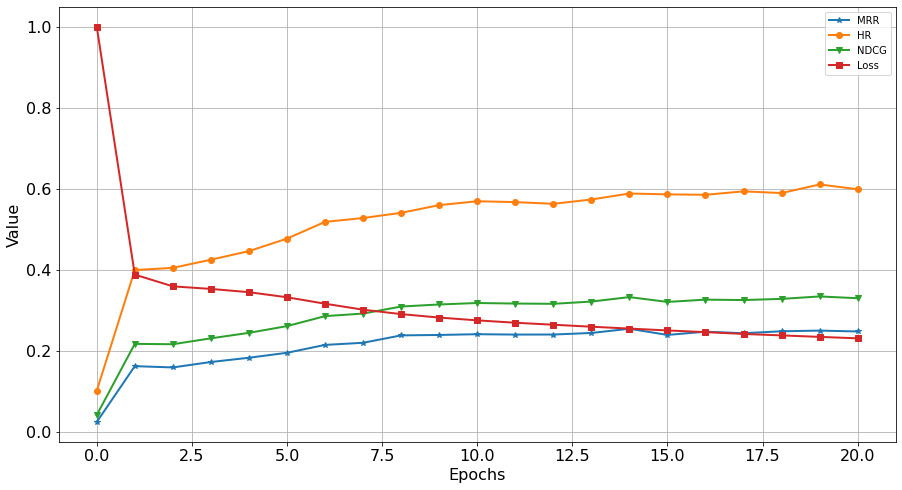

In [24]:
deterministic()

try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

model = RecSysNet(
    n_users=train_matrix.shape[0], 
    n_items=train_matrix.shape[1],
    embedding_dim=128 
).to(device)    

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters())

TOPK = 10
N_EPOCHS = 20
BCE_loss_list, hr_list, ndcg_list, mrr_list = [], [], [], []

# --> Check init performance
hr, ndcg, mrr = test(model, test_ratings, test_negatives, TOPK)
print()
hr_list.append(hr)
ndcg_list.append(ndcg)
mrr_list.append(mrr)
BCE_loss_list.append(1)


training_stats = []
for epoch in range(1, N_EPOCHS+1):
    loss_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch, N_EPOCHS, device)
    hr, ndcg, mrr = test(model, test_ratings, test_negatives, TOPK)
    mrr_list.append(mrr)
    hr_list.append(hr)
    ndcg_list.append(ndcg)
    BCE_loss_list.append(loss_train)

    training_stats.append(
        {
            'epoch': epoch, 
            'Training Loss': loss_train, 
            'MRR': mrr, 
            'HR': hr,
            'NDCG':ndcg,
        }
            )

best_iter = np.argmax(np.array(mrr_list))
best_mrr = mrr_list[best_iter]
best_hr = hr_list[best_iter]
best_ndcg = ndcg_list[best_iter]

print(f"End. Best Iteration {best_iter}. MRR: {best_mrr :.4} -- HR: {best_hr :.4} -- NDCG: {best_ndcg :.4}")

plot_statistics(mrr_list, hr_list, ndcg_list, BCE_loss_list)

In [25]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
pd.set_option('precision', 2)
df_stats

,Training Loss,MRR,HR,NDCG
epoch,,,,
1,0.39,0.16,0.40,0.22
2,0.36,0.16,0.41,0.22
3,0.35,0.17,0.43,0.23
4,0.35,0.18,0.45,0.24
5,0.33,0.20,0.48,0.26
6,0.32,0.22,0.52,0.29
7,0.30,0.22,0.53,0.29
8,0.29,0.24,0.54,0.31
9,0.28,0.24,0.56,0.31
